# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectFromModel

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

male      577
female    314
Name: Sex, dtype: int64
0    549
1    342
Name: Survived, dtype: int64
Sex     Survived
male    0           0.525253
female  1           0.261504
male    1           0.122334
female  0           0.090909
dtype: float64


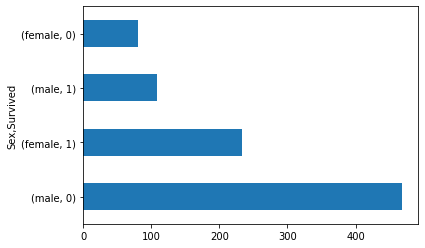

In [6]:
from seaborn import heatmap
print (data['Sex'].value_counts())
print (data['Survived'].value_counts())
print (data[['Sex', 'Survived']].value_counts(normalize=True))
data[['Sex', 'Survived']].value_counts().plot.barh(stacked=True)
plt.show()

< your thoughts >
We can see on the graphic, more died peoples was men, but it was more men than women on the ship too.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <a list of 10 Patch objects>)

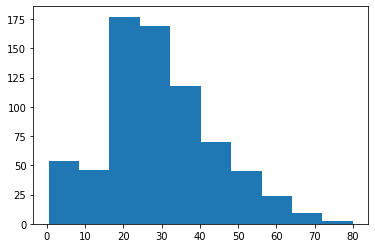

In [7]:
plt.hist(data['Age'])

In [8]:
data['Age'].groupby(data['Survived']).mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

In [9]:
data['Age'].groupby(data['Survived']).median()

Survived
0    28.0
1    28.0
Name: Age, dtype: float64

In [10]:
data['Age'].mean()

29.69911764705882

< your thoughts > Average and the median age of survived and deceased passengers differ slightly, so this column does not have a big influence to the result.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

3    491
1    216
2    184
Name: Pclass, dtype: int64


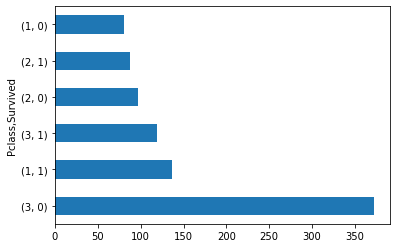

In [11]:
print (data['Pclass'].value_counts())
data[['Pclass', 'Survived']].value_counts().plot.barh(stacked=True)

S    644
C    168
Q     77
Name: Embarked, dtype: int64


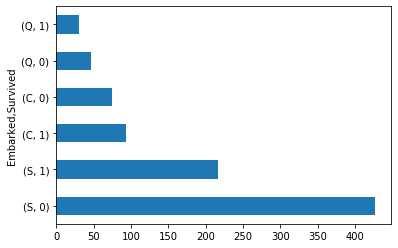

In [12]:
print (data['Embarked'].value_counts())
data[['Embarked', 'Survived']].value_counts().plot.barh(stacked=True)

< your thoughts > Most poor people (workers - 3 class) is deceased, because they was lived on the first's desks of Titanic. And most passengers started theirs trip from point S and dead too.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [13]:
data.isnull().mean()

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >The are just few missing rows on column "Embarked" - drop. Most poor people haden't cabins - we"ll mark NaN by U (Undefinded). For the Age, we'll remplace for the mean value.

**(2.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [14]:
data['Cabin'] = data['Cabin'].fillna('U')
data=data[data['Embarked'].notna()]
data['Age'] = data['Age'].fillna(value=data['Age'].mean())
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S


In [15]:
data.isnull().mean()

Survived    0.0
Pclass      0.0
Name        0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Ticket      0.0
Fare        0.0
Cabin       0.0
Embarked    0.0
dtype: float64

In [16]:
y = data['Survived']

In [17]:
embarked_one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked')
data = pd.concat([data, embarked_one_hot], axis=1)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,0,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,0,0,1


In [18]:
data['Cabin'] = data['Cabin'].apply(lambda x: x[0])
cabin_one_hot = pd.get_dummies(data['Cabin'], prefix='Cabin')
data = pd.concat([data, cabin_one_hot], axis=1)

In [19]:
sex_one_hot = pd.get_dummies(data['Sex'], prefix='Sex')
data = pd.concat([data, sex_one_hot], axis=1)

In [20]:
data['Name']

PassengerId
1                                Braund, Mr. Owen Harris
2      Cumings, Mrs. John Bradley (Florence Briggs Th...
3                                 Heikkinen, Miss. Laina
4           Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                               Allen, Mr. William Henry
                             ...                        
887                                Montvila, Rev. Juozas
888                         Graham, Miss. Margaret Edith
889             Johnston, Miss. Catherine Helen "Carrie"
890                                Behr, Mr. Karl Howell
891                                  Dooley, Mr. Patrick
Name: Name, Length: 889, dtype: object

In [21]:
#для получения обращений
def get_title(x):
    return x.split(',')[1].split('.')[0].strip()

In [22]:
data['Title'] = data['Name'].apply(get_title)
title_one_hot = pd.get_dummies(data['Title'], prefix='Title')
data = pd.concat([data, title_one_hot], axis=1)

data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [23]:
age_median = data.groupby('Title')['Age'].median()
age_median

Title
Capt            70.000000
Col             58.000000
Don             40.000000
Dr              44.000000
Jonkheer        38.000000
Lady            48.000000
Major           48.500000
Master           4.000000
Miss            24.000000
Mlle            24.000000
Mme             24.000000
Mr              29.642093
Mrs             32.500000
Ms              28.000000
Rev             46.500000
Sir             49.000000
the Countess    33.000000
Name: Age, dtype: float64

In [24]:
# функция определения пропущенного возраста по обращению
def fill_age(x):
    for index, age in zip(age_median.index, age_median.values):
        if x['Title'] == index:
            return age
#data['Age'] = data.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)
#модель стала только хуже

In [25]:
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
print (data.columns)
print (data.dtypes)

col = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'Sex_female', 'Sex_male',
       'FamilySize', 'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dr',
       'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master',
       'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs',
       'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess']
X= data[col]

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_U', 'Sex_female', 'Sex_male', 'Title',
       'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer',
       'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle',
       'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev',
       'Title_Sir', 'Title_the Countess', 'FamilySize'],
      dtype='object')
Survived                int64
Pclass                  int64
Name                   object
Sex                    object
Age                   float64
SibSp                   int64
Parch                   int64
Ticket                 object
Fare                  float64
Cabin                  object
Embarked               object
Embarked_C              uint8
Embarked_Q              uint8

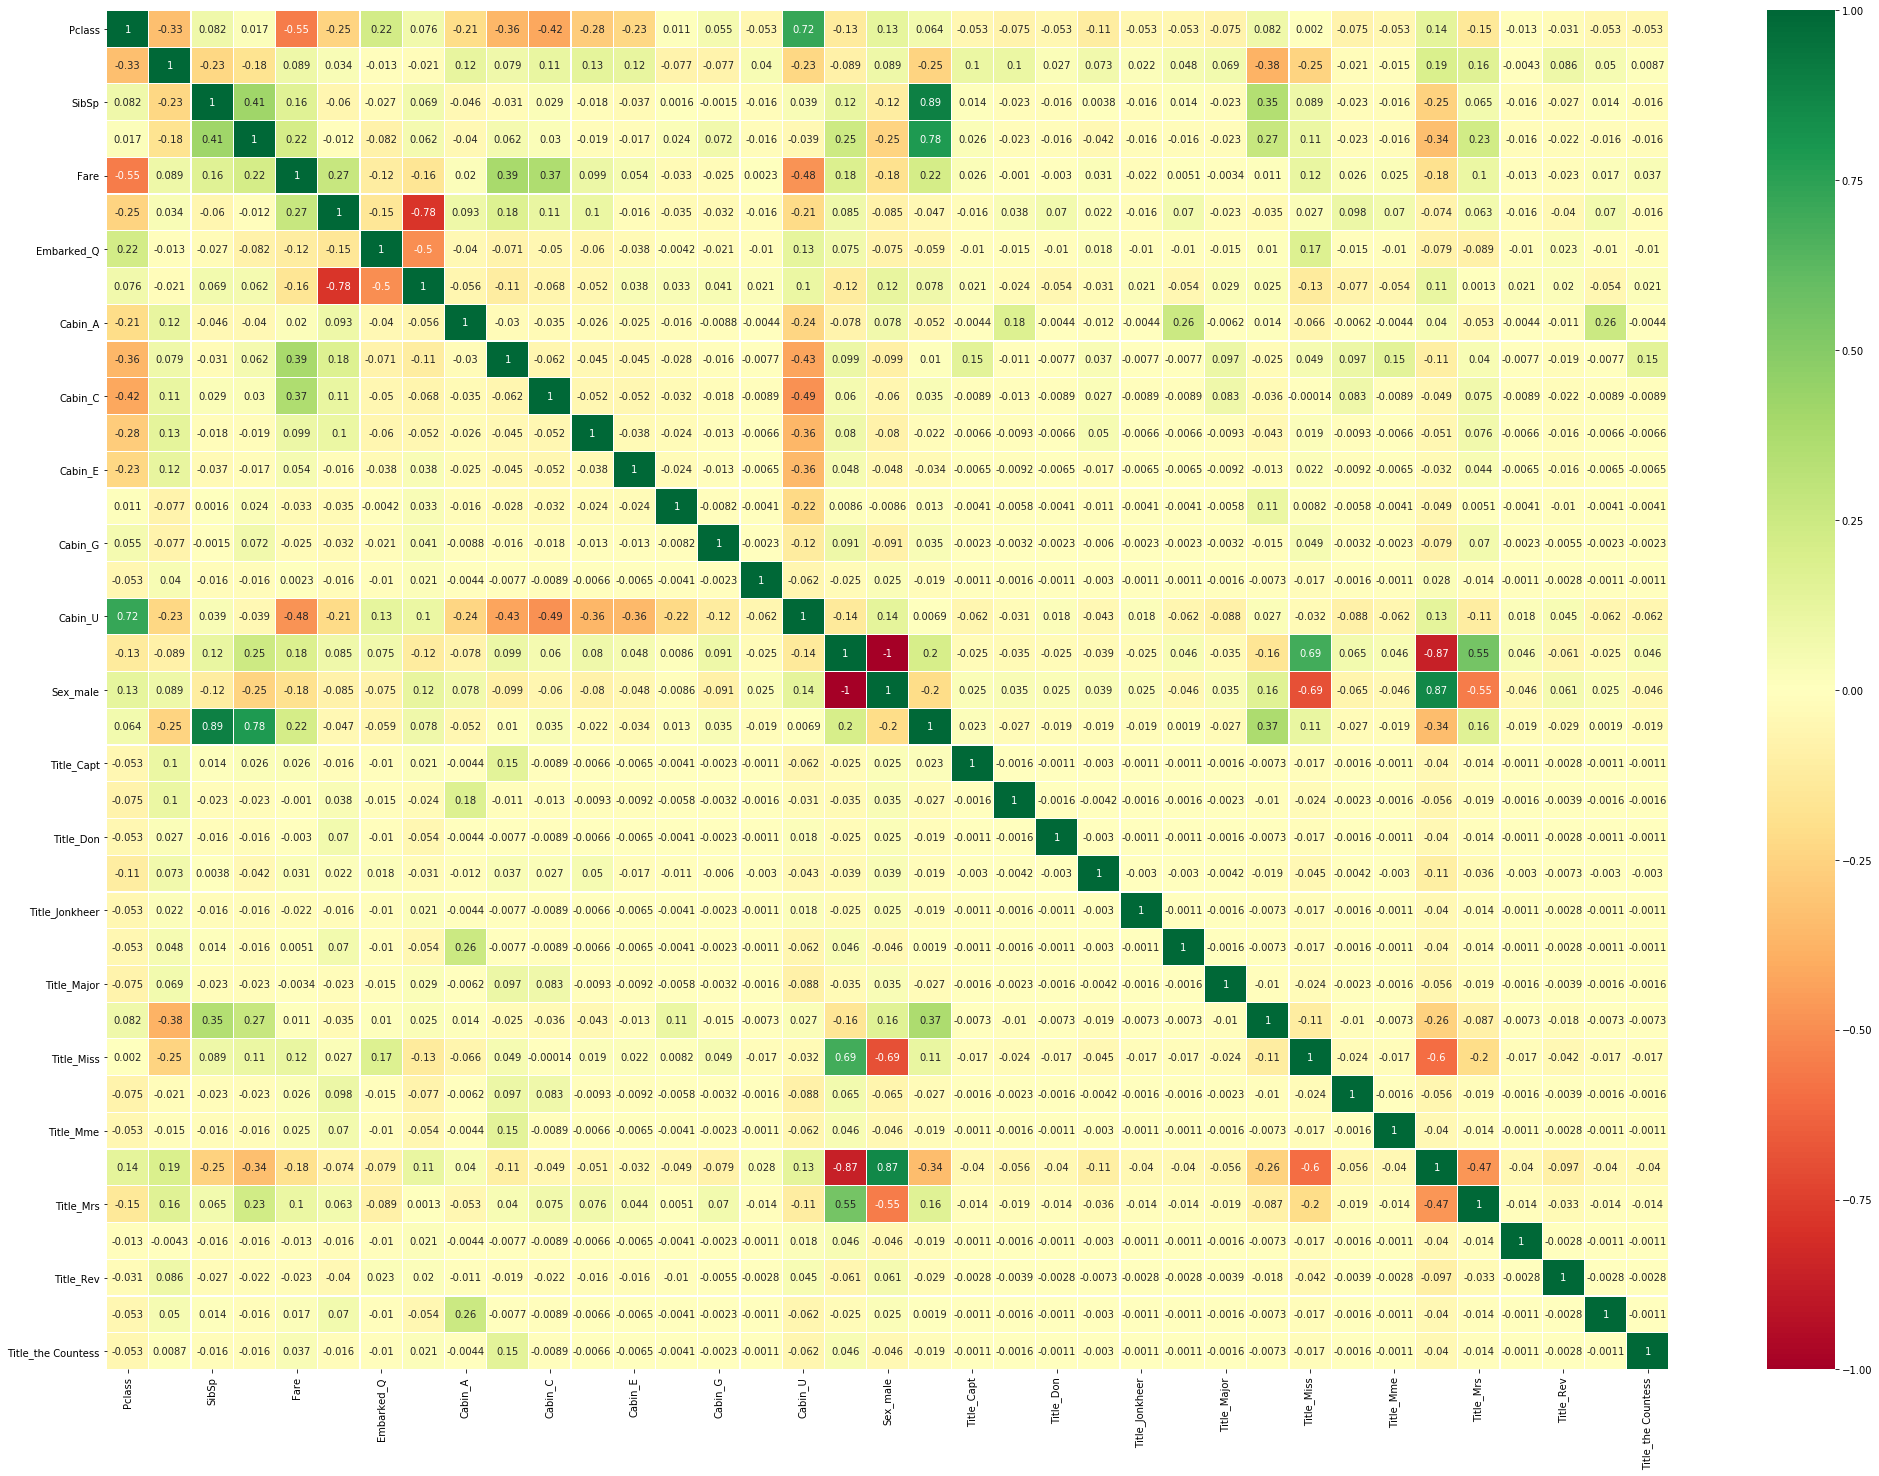

In [26]:
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(35,25)
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split

modKNN= KNeighborsClassifier(n_neighbors=24)
modLR= LogisticRegression()

print('Accuracy of model KNN: {:f}'.format(cross_val_score(modKNN, X, y, 
                      scoring='accuracy', cv=3).mean()))

print('Accuracy of model LogisticRegression: {:f}'.format(cross_val_score(modLR, X, y, 
                      scoring='accuracy', cv=3).mean()))

The LogisticRegression is better than KNN, so we'll work  with the LogisticRegression.

**(1.5 points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression.

In [28]:
#Logistic Regression
model= LogisticRegression(solver='liblinear', penalty='l2',random_state=21, n_jobs=50)
selection_model = RandomForestClassifier(random_state=21)
pipe_selection1 = make_pipeline(MinMaxScaler(), SelectFromModel(model), model)
l= cross_val_score(pipe_selection1, X, y, scoring='accuracy', cv=10).mean()
print('Accuracy of scaled of model LogisticRegression {:f}'.format(l))

Accuracy of scaled of model LogisticRegression 0.824553


C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 50.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 50.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 50.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 50.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\User\Anaconda3\lib\site-packages\sk

Load the test set and make the predictions. Submit them to kaggle and see the results :)

In [29]:
da = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
da['Cabin'] = da['Cabin'].fillna('U')
da=da[da['Embarked'].notna()]
da['Age'] = da['Age'].fillna(value=da['Age'].mean())
da.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,U,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,U,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,U,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,U,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,U,S


In [30]:
da['Fare'] = da['Fare'].fillna(value=da['Fare'].mean())
embarked_one_hot1 = pd.get_dummies(da['Embarked'], prefix='Embarked')
da = pd.concat([da, embarked_one_hot1], axis=1)

da['Cabin'] = da['Cabin'].apply(lambda x: x[0])
cabin_one_hot1 = pd.get_dummies(da['Cabin'], prefix='Cabin')

da = pd.concat([da, cabin_one_hot1], axis=1)
sex_one_hot1 = pd.get_dummies(da['Sex'], prefix='Sex')
da = pd.concat([da, sex_one_hot1], axis=1)
da['FamilySize'] = da['SibSp'] + da['Parch'] + 1
da['Title'] = da['Name'].apply(get_title)
title_one_hot1 = pd.get_dummies(da['Title'], prefix='Title')
da = pd.concat([da, title_one_hot1], axis=1)
#da['Age'] = da.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1)
not_in = ['Cabin_T', 'Title_Lady', 'Title_Capt', 'Title_Major', 'Title_Mlle', 'Title_Don', 'Title_Sir', 'Title_Mme', 'Title_Jonkheer', 'Title_the Countess']

da[not_in] = 0
print (data.dtypes)

Survived                int64
Pclass                  int64
Name                   object
Sex                    object
Age                   float64
SibSp                   int64
Parch                   int64
Ticket                 object
Fare                  float64
Cabin                  object
Embarked               object
Embarked_C              uint8
Embarked_Q              uint8
Embarked_S              uint8
Cabin_A                 uint8
Cabin_B                 uint8
Cabin_C                 uint8
Cabin_D                 uint8
Cabin_E                 uint8
Cabin_F                 uint8
Cabin_G                 uint8
Cabin_T                 uint8
Cabin_U                 uint8
Sex_female              uint8
Sex_male                uint8
Title                  object
Title_Capt              uint8
Title_Col               uint8
Title_Don               uint8
Title_Dr                uint8
Title_Jonkheer          uint8
Title_Lady              uint8
Title_Major             uint8
Title_Mast

In [31]:
da.isnull().mean()

Pclass                0.0
Name                  0.0
Sex                   0.0
Age                   0.0
SibSp                 0.0
Parch                 0.0
Ticket                0.0
Fare                  0.0
Cabin                 0.0
Embarked              0.0
Embarked_C            0.0
Embarked_Q            0.0
Embarked_S            0.0
Cabin_A               0.0
Cabin_B               0.0
Cabin_C               0.0
Cabin_D               0.0
Cabin_E               0.0
Cabin_F               0.0
Cabin_G               0.0
Cabin_U               0.0
Sex_female            0.0
Sex_male              0.0
FamilySize            0.0
Title                 0.0
Title_Col             0.0
Title_Dona            0.0
Title_Dr              0.0
Title_Master          0.0
Title_Miss            0.0
Title_Mr              0.0
Title_Mrs             0.0
Title_Ms              0.0
Title_Rev             0.0
Cabin_T               0.0
Title_Lady            0.0
Title_Capt            0.0
Title_Major           0.0
Title_Mlle  

In [32]:
X_test= da[col]
k = pipe_selection1.fit(X,y)
y_t= k.predict (X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 50.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 50.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [33]:
ans = pd.DataFrame(y_t, index= X_test.index)
ans.columns = ['Survived']
ans.to_csv('ans.csv', sep=',')

In [34]:
ans

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


The first result was 0.762 and I maked lot of improvements to have 0.77272... The time is not worth the result.

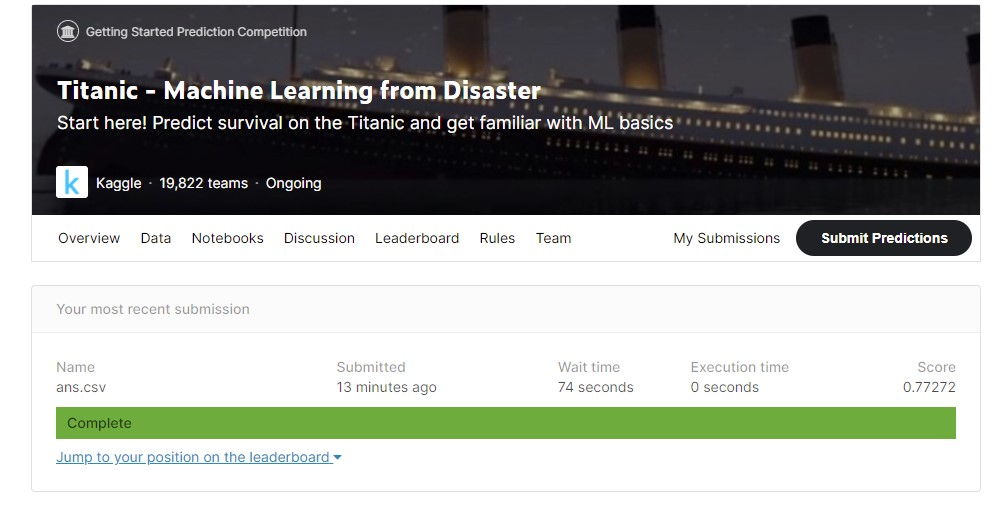

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [35]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [36]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [37]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [38]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

NameError: name 'OneHotEncoder' is not defined

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [ ]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

In [ ]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [ ]:
insurance_data.describe()

As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [ ]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [ ]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [ ]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [ ]:
gini_normalized(y_valid, y_pred)

**(1.5 points + X bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
X bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [ ]:
## your code